In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping
314 movies had actors with the same name, dropping

Merging Oscar dataset, after merge:
Number of different Oscar nominated movies in dataset: 952 in total 63968 different movies
Number of different Oscar nominated actors in dataset: 801 in total 134907 different actors
Number of Oscar nominated rows: 1443

Merging IMDb dataset, after merge:
Number of movies with ratings: 36757
Oscar nominated movies with rating: 939
Number of rows in data before cleaning:  443504
Number of rows in data after cleaning:  23819

FINAL STATE OF DATA
Number of rows:  23819
Number of different Oscar nominated movies in dataset: 394 in total 5989 different movies
Number of different Oscar nominated actors in dataset: 284 in total 2962 different actors
Number of Oscar nominated rows: 519
Processing done, dataset written to cache/data.csv


In [142]:
import pandas as pd

# Load the data
genres_df = pd.read_parquet('cache/genres.parquet')
languages_df = pd.read_parquet('cache/languages.parquet')
countries_df = pd.read_parquet('cache/countries.parquet')
data_df = pd.read_parquet('cache/data.parquet')
data_df['oscar_nominated'] = data_df['oscar_nominated'].astype(float)
data_df.head()

,title,box_office_revenue,runtime,languages,countries,genres,movie_identifier,actor_gender,actor_height,actor_ethnicity,actor_age,parsed_actor_name,actor_identifier,identifier,category,winner,oscar_nominated,year,average_rating,number_of_votes
0,Ghosts of Mars,14010832,98,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",ghosts of mars_2001,M,1.727,/m/0x67,32,ice cube,/m/01vw26l,ghosts of mars_2001_ice cube,None,None,0.0,2001,4.9,58894
4,Ghosts of Mars,14010832,98,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",ghosts of mars_2001,F,1.780,/m/044038p,27,natasha henstridge,/m/0346l4,ghosts of mars_2001_natasha henstridge,None,None,0.0,2001,4.9,58894
11,Ghosts of Mars,14010832,98,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",ghosts of mars_2001,F,1.727,/m/0x67,52,pam grier,/m/0418ft,ghosts of mars_2001_pam grier,None,None,0.0,2001,4.9,58894
51,Alexander's Ragtime Band,3600000,106,[English Language],[United States of America],"[Musical, Comedy]",alexanders ragtime band_1938,M,1.820,/m/06v41q,24,tyrone power,/m/02s58t,alexanders ragtime band_1938_tyrone power,None,None,0.0,1938,6.8,2357
52,Alexander's Ragtime Band,3600000,106,[English Language],[United States of America],"[Musical, Comedy]",alexanders ragtime band_1938,F,1.650,/m/033tf_,23,alice faye,/m/032xfz,alexanders ragtime band_1938_alice faye,None,None,0.0,1938,6.8,2357


### Find number of movies the actor starred in prior to starring in the current movie

In [143]:
# Sort movies by year 
data_df = data_df.loc[data_df['year'].notna(), :]
data_df = data_df.sort_values('year', ascending=True)

# Get cumulative count of movies for each actor
data_df['number_of_movies_starred_in'] = data_df.groupby('actor_identifier').cumcount() + 1

### Find distribution of number of movies actors star in

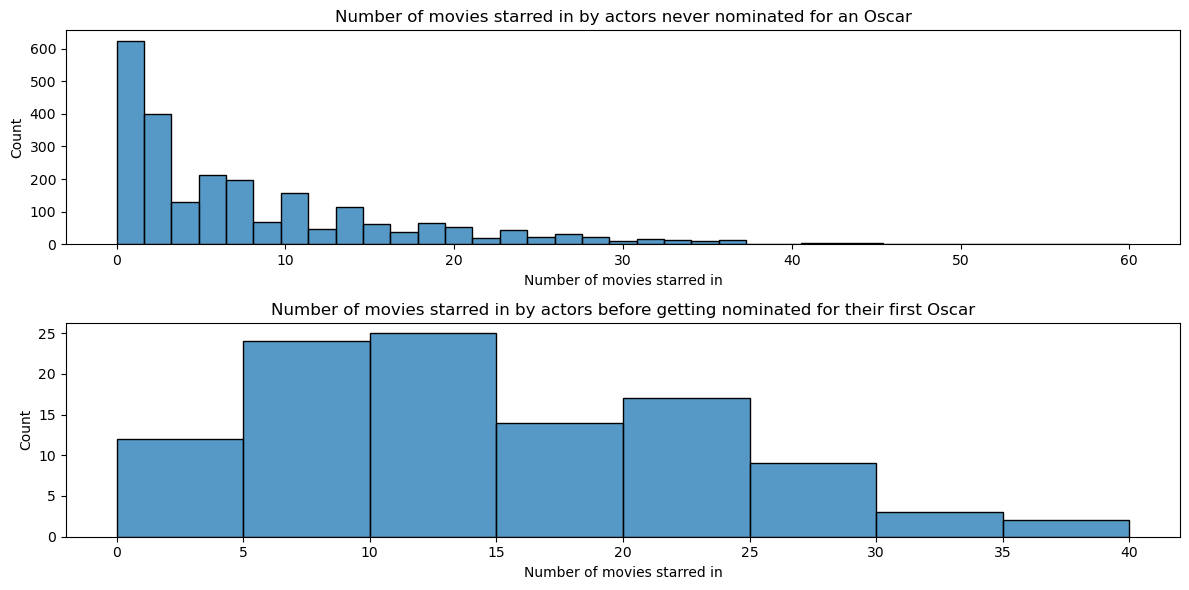

In [109]:
# The cumulative count does not make sense for the earlier movies since we don't count movies
# prior to that. We set the year to 2000 since now this issue would only occur if actors starred in a movie
# prior to 1928 and were nominated for an Oscar after 2000. Which is unlikely.

oscar_nominated_plot_df = data_df.loc[(data_df['oscar_nominated'] == 1) & (data_df['year'] > 2000)].groupby('actor_identifier').agg(
    movies_starred_in=('number_of_movies_starred_in', 'min')).reset_index()
not_oscar_nominated_plot_df = data_df.loc[(data_df['oscar_nominated'] == 0) & (data_df['year'] > 2000)].groupby('actor_identifier').agg(
    movies_starred_in=('number_of_movies_starred_in', 'max')).reset_index()

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(data=not_oscar_nominated_plot_df, x='movies_starred_in', ax=axs[0], log_scale=False)
sns.histplot(data=oscar_nominated_plot_df, x='movies_starred_in', ax=axs[1], log_scale=False)

axs[0].set_title('Number of movies starred in by actors never nominated for an Oscar')
axs[1].set_title('Number of movies starred in by actors before getting nominated for their first Oscar')

axs[0].set_xlabel('Number of movies starred in')
axs[1].set_xlabel('Number of movies starred in')

plt.tight_layout()
plt.show()

In [89]:
print('Mean number of movies starred in by actors never nominated for an Oscar: ', not_oscar_nominated_plot_df['movies_starred_in'].mean())
print('Mean number of movies starred in by actors before getting nominated for their first Oscar: ', oscar_nominated_plot_df['movies_starred_in'].mean())

Mean number of movies starred in by actors never nominated for an Oscar:  7.980753138075314
Mean number of movies starred in by actors before getting nominated for their first Oscar:  14.264150943396226


In [ ]:
# Do a p-test to see if the difference is significant
from scipy.stats import ttest_ind

ttest_result = ttest_ind(not_oscar_nominated_plot_df['movies_starred_in'], oscar_nominated_plot_df['movies_starred_in'])
print('P-value: ', ttest_result.pvalue)

P-value:  1.399642456724483e-12


The p-value is less than 5%, thus we conclude the distributions to be different.

We conclude that actors who got nominated for Oscars in the 21th centaury on average starred in 14 movies. 

### Do the chance of winning an Oscar increase because you have more entries (as in more movies) or because of something else? (2000 >)

Probability of getting nominated for an Oscar after starring in one movie:  0.012145056448853917


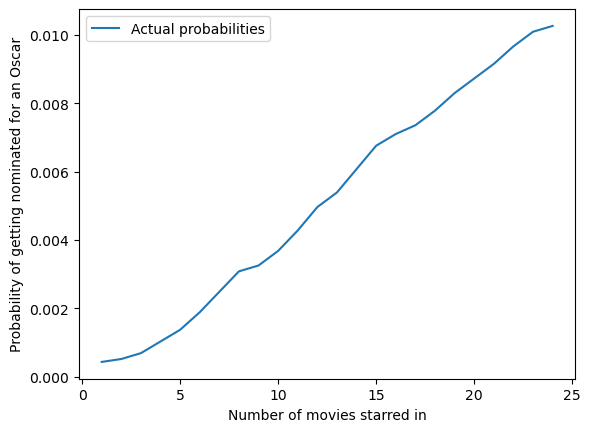

In [107]:
# Assuming each movie is independent of the other
# Probability of getting nominated for an Oscar after starring in one movie
filtered_df = data_df.loc[data_df['year'] > 2000]
iid_p = filtered_df.loc[filtered_df['oscar_nominated'] == 1].shape[0] / filtered_df.shape[0]
print('Probability of getting nominated for an Oscar after starring in one movie: ', iid_p)

nominated_df = filtered_df.loc[filtered_df['oscar_nominated'] == 1]

actual_probabilities = []
iid_probabilities = []

for i in range(1, 25):
    actual_probabilities.append(nominated_df.loc[nominated_df['number_of_movies_starred_in'] <= i].shape[0] / filtered_df.shape[0])
    iid_probabilities.append(1 - (1 - iid_p) ** i)


plt.plot(range(1, 25), actual_probabilities, label='Actual probabilities')
# plt.plot(range(1, 25), iid_probabilities, label='IID probabilities')
plt.xlabel('Number of movies starred in')
plt.ylabel('Probability of getting nominated for an Oscar')
plt.legend()
plt.show()





<Axes: xlabel='number_of_movies_starred_in', ylabel='average_rating'>

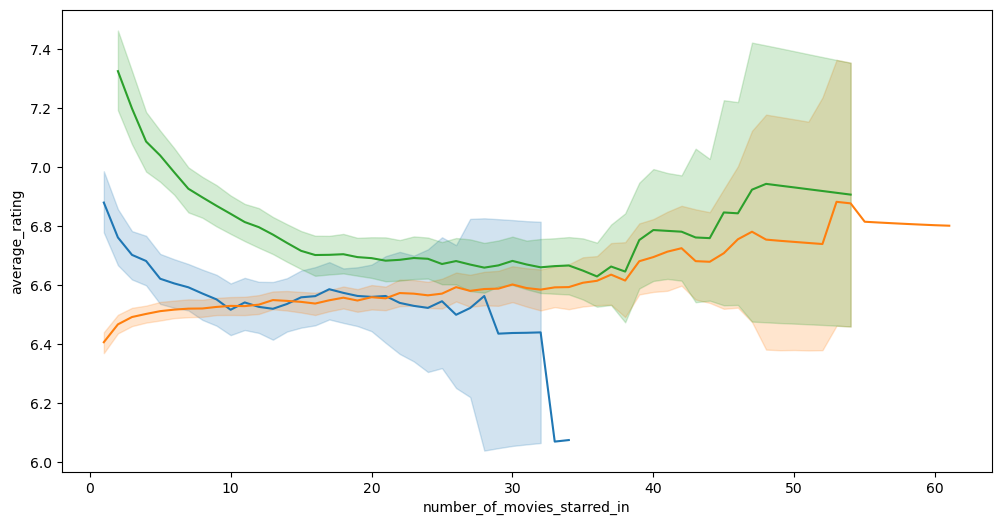

In [162]:
data_df['cumulative_rating'] = data_df.groupby('actor_identifier')['average_rating'].cumsum()
data_df['average_rating'] = data_df['cumulative_rating'] / data_df['number_of_movies_starred_in']

# Removing rows after actor's first Oscar nomination
oscar_nominated_df = data_df.loc[data_df['oscar_nominated'] == 1]
non_oscar_nominated_df = data_df.loc[data_df['oscar_nominated'] == 0]

oscar_nominated_grouped_df = oscar_nominated_df.groupby('actor_identifier').agg(
    first_oscar_nominated_year=('year', 'min')).reset_index()

before_oscar_nominated_df = oscar_nominated_grouped_df.merge(data_df, on='actor_identifier')
before_oscar_nominated_df = before_oscar_nominated_df.loc[before_oscar_nominated_df['year'] <= before_oscar_nominated_df['first_oscar_nominated_year']]

after_oscar_nominated_df = oscar_nominated_grouped_df.merge(data_df, on='actor_identifier')
after_oscar_nominated_df = after_oscar_nominated_df.loc[after_oscar_nominated_df['year'] > after_oscar_nominated_df['first_oscar_nominated_year']]

# # oscar_nominated_df = oscar_nominated_df.groupby('actor_identifier').agg(
# #     average_box_office=('average_box_office', 'last'),
# #     number_of_movies_starred_in=('number_of_movies_starred_in', 'last')).reset_index()

# # non_oscar_nominated_df = non_oscar_nominated_df.groupby('actor_identifier').agg(
# #     average_box_office=('average_box_office', 'last'),
# #     number_of_movies_starred_in=('number_of_movies_starred_in', 'last')).reset_index()

# fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='tight', sharey=True, sharex=True)

# sns.scatterplot(data=before_oscar_nominated_df, x='number_of_movies_starred_in', y='average_box_office', ax=axs[0])
# sns.scatterplot(data=after_oscar_nominated_df, x='number_of_movies_starred_in', y='average_box_office', ax=axs[1])

# axs[0].set_title('Actors before their first Oscar nomination')
# axs[1].set_title('Actors who have never been nominated for an Oscar at the time of their last movie')

# axs[0].set_xlabel('Number of movies starred in')
# axs[1].set_xlabel('Number of movies starred in')
# axs[0].set_ylabel('Average box office revenue up until that point')

# plt.legend()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.lineplot(data=before_oscar_nominated_df, x='number_of_movies_starred_in', y='average_rating', orient='x', ax=ax)
sns.lineplot(data=non_oscar_nominated_df, x='number_of_movies_starred_in', y='average_rating', orient='x', ax=ax)
sns.lineplot(data=after_oscar_nominated_df, x='number_of_movies_starred_in', y='average_rating', orient='x', ax=ax)